# Профилирование и оптимизация вычислений Dask

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. Лекция "Dask"
* https://docs.dask.org/en/stable/diagnostics-local.html#profiler
* https://docs.dask.org/en/stable/diagnostics-local.html#progress-bar
* https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.broken_barh.html
* https://docs.python.org/3/library/stdtypes.html#str.rsplit
* https://docs.dask.org/en/stable/api.html#dask.datasets.make_people
* https://docs.dask.org/en/stable/scheduling.html
* https://distributed.dask.org/en/stable/client.html

## Задачи для совместного разбора

In [2]:
#!pip install dask==2023.3.2
#!pip install distributed==2023.3.2

1\. Создайте массив целых чисел. Вычислите среднее значение элементов. Для демонстрации прогресса используйте ProgressBar. Модифицируйте ProgressBar.

In [2]:
import dask.array as da
from dask.diagnostics import ProgressBar

a = da.random.randint(0, 100, size=(100000, 10000))

In [3]:
%%time
avg = a.mean()
avg.compute()

Wall time: 1.78 s


49.500963153

In [4]:
with ProgressBar():
    avg.compute()

[########################################] | 100% Completed | 1.66 sms


In [5]:
import contextlib

In [6]:
class MyProgressBar(ProgressBar):
    def __init__(self, char: str = "#"):
        super().__init__()
        self.char = char
        
    def _draw_bar(self, frac, elapsed):
        from dask.utils import format_time

        bar = self.char * int(self._width * frac)
        percent = int(100 * frac)
        elapsed = format_time(elapsed)
        msg = "\r[{0:<{1}}] | {2}% Completed | {3}".format(
            bar, self._width, percent, elapsed
        )
        with contextlib.suppress(ValueError):
            if self._file is not None:
                self._file.write(msg)
                self._file.flush()

with MyProgressBar(char="|"):
    avg.compute()

[||||||||||||||||||||||||||||||||||||||||] | 100% Completed | 1.69 sms


2\. Отберите строки, сумма элементов которых является четной. Вычислите среднее значение полученного массива, используя различные планировщики. 

In [7]:
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

In [8]:
%%time
b.mean().compute(scheduler="threads")

Wall time: 1.78 s


49.500268965379306

In [9]:
%%time
b.mean().compute(scheduler="processes")

OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

In [10]:
%%time
b.mean().compute(scheduler="sync")

Wall time: 9.85 s


49.500268965379306

3\. Изучите, как влияет вызов persist на скорость вычислений максимума и среднего значения элементов массива из предыдущей задачи.

In [11]:
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

m = b.max()
avg = b.mean()

In [12]:
%%time
m.compute(), avg.compute()

Wall time: 3.54 s


(99, 49.50023707753083)

In [13]:
import dask

In [14]:
%%time
dask.compute(m, avg)

Wall time: 1.85 s


(99, 49.50023707753083)

In [15]:
%%time
# так не надо
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask].compute()
# b - np.array
m = b.max()
avg = b.mean()
print(m, avg)

99 49.497748329193044
Wall time: 3.43 s


In [16]:
%%time
a = da.random.randint(0, 100, size=(100000, 10000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask].persist()

Wall time: 1.76 s


In [17]:
b

dask.array<getitem_variadic, shape=(nan, 10000), dtype=int32, chunksize=(nan, 5792), chunktype=numpy.ndarray>

In [18]:
m = b.max()
avg = b.mean()

In [19]:
m

dask.array<amax-aggregate, shape=(), dtype=int32, chunksize=(), chunktype=numpy.ndarray>

In [20]:
%%time
m.compute(), avg.compute()

Wall time: 179 ms


(99, 49.501623401997875)

In [21]:
%%time
b.compute()

Wall time: 888 ms


array([[83, 97, 97, ..., 61, 96, 75],
       [58, 53, 48, ..., 38, 28, 55],
       [80, 10, 58, ..., 65, 31, 32],
       ...,
       [30, 96, 99, ..., 56, 71, 69],
       [78, 15, 35, ..., 75, 45, 80],
       [80, 31, 94, ..., 53, 23, 57]])

4\. Изучите основные возможности Client на примере предыдущей задачи.

In [22]:
#!pip install bokeh==2.4.3

In [23]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63023,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.81 GiB
Comm: tcp://127.0.0.1:63044,Total threads: 3
Dashboard: http://127.0.0.1:63049/status,Memory: 3.95 GiB
Nanny: tcp://127.0.0.1:63026,


In [24]:
a = da.random.randint(0, 100, size=(100000, 100000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

In [25]:
b.mean().compute()

49.49943565302848

In [26]:
%%time
a = da.random.randint(0, 100, size=(100000, 100000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

b.mean().compute()

print("1")

1
Wall time: 18.5 s


In [28]:
%%time
a = da.random.randint(0, 100, size=(100000, 100000))
mask = a.sum(axis=1) % 2 == 0
b = a[mask]

f = client.compute(b.mean())

print("1")

1
Wall time: 171 ms


In [29]:
f

<Future: pending, key: finalize-ca17251baf6e2a40a2bccc8d76232730>

In [30]:
f.result()

49.500302956689666

In [32]:
client.close()

## Лабораторная работа 11

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

In [1]:
import dask.array as da
import dask
from dask.diagnostics import ProgressBar
from dask.diagnostics import Profiler
import pandas as pd
import matplotlib.pyplot as plt
from dask.distributed import Client

__Важно: задачи 1-7 решаются без запуска клиента `dask.distributed.Client`__

<p class="task" id="1"></p>

1\. Создайте массив из 1 млн. строк и 256 столбцов, заполненный числами из нормального распределения с $\mu=10$ и $\sigma=5$. При помощи метода `rechunk` сделайте так, чтобы данные были разбиты на сегменты по 250 тыс. строк.

Используя `dask.diagnostics.Profiler`, исследуйте процесс вычисления суммы элементов этого массива. Результат представьте в виде `pd.DataFrame` со столбцами: `key`, `start_time`, `end_time`, `worker_id`, `time_taken` и `task_type`. В поле `key` должны храниться строки - идентификаторы задач. 

В поле `task_type` должны храниться строки - типы задач, которые можно извлечь из `key`. Например, для строки "normal-33a0474c5b5133263153dbd93d8fa610" категорией является "normal", а для строки "rechunk-merge-sum-290d08054ec62d2e1cd1c42b68f" - "rechunk-merge-sum".

Выведите на экран количество задач и количество уникальных типов этих задач

In [2]:
s1 = da.random.normal(10, 5, size=(1_000_000,256))
s1 = s1.rechunk((250_000, -1))
s1

dask.array<rechunk-merge, shape=(1000000, 256), dtype=float64, chunksize=(250000, 256), chunktype=numpy.ndarray>

In [3]:
%%time
with Profiler() as prof:
    res1 = s1.sum().compute()

res1

Wall time: 1.51 s


2559971322.17543

In [4]:
def create_row(x):
#    key = x[0][0].split('-')[-1]
#    task_type = '-'.join(x[0][0].split('-')[:-1])
    task_type, key = x[0][0].rsplit('-', maxsplit=1)
    start_time, end_time, worker_id = x[2:]
    time_taken = end_time - start_time
    
    return [key, start_time, end_time, worker_id, time_taken, task_type]

In [5]:
data = map(
    create_row,
    prof.results
)

df1 = pd.DataFrame(data, columns=['key', 'start_time', 'end_time', 'worker_id', 'time_taken', 'task_type'])
df1.head()

,key,start_time,end_time,worker_id,time_taken,task_type
0,1bc60e5266f5eb0c1c3b144477d9b8b9,6.060465,6.812495,29840,0.752030,normal
1,1bc60e5266f5eb0c1c3b144477d9b8b9,6.060472,6.790854,25084,0.730382,normal
2,1bc60e5266f5eb0c1c3b144477d9b8b9,6.060477,6.812137,6984,0.751660,normal
3,1bc60e5266f5eb0c1c3b144477d9b8b9,6.060482,6.759616,34112,0.699134,normal
4,1bc60e5266f5eb0c1c3b144477d9b8b9,6.060487,6.792773,26952,0.732286,normal


In [6]:
df1.shape[0] # количество задач

33

In [7]:
df1['task_type'].nunique() # количество уникальных типов этих задач

6

<p class="task" id="2"></p>

2\. Профайлер `dask.diagnostics.Profiler` возвращает временные метки `start_time` и `end_time`, начиная с момента запуска ядра ноутбука. Напишите собственную версию профайлера `ProfilerWithInitialTimestamp`, который возвращает результаты замеров времени, начиная с момента запуска ячейки. Результат представьте в виде `pd.DataFrame` со столбцами: `key`, `start_time`, `end_time`, `worker_id`, `time_taken` и `task_type` аналогично заданию 1. Выведите на экран минимум и максимум по столбцу `start_time`.

In [8]:
from timeit import default_timer
from timeit import timeit
import time

In [9]:
class ProfilerWithInitialTimestamp(Profiler):
    def __init__(self):
        super().__init__()
        self.zero_time = time.time()

    def __enter__(self):
        self.clear()
        self.start_time = time.time() - self.zero_time
        return super().__enter__()

    def __exit__(self, *args):
        self.end_time = time.time() - self.zero_time
        return super().__exit__(*args)
    
    def _pretask(self, key, dsk, state):
        start = time.time() - self.zero_time
        self._results[key] = (key, dsk[key], start)

    def _posttask(self, key, value, dsk, state, id):
        end = time.time() - self.zero_time
        self._results[key] += (end, id)

In [10]:
%%time
with ProfilerWithInitialTimestamp() as prof2:
    res2 = s1.sum().compute()

res2

Wall time: 1.57 s


2559971322.17543

In [11]:
data2 = map(
    create_row,
    prof2.results
)

df2 = pd.DataFrame(data2, columns=['key', 'start_time', 'end_time', 'worker_id', 'time_taken', 'task_type'])
df2.head()

,key,start_time,end_time,worker_id,time_taken,task_type
0,1bc60e5266f5eb0c1c3b144477d9b8b9,0.003988,0.755107,6984,0.751119,normal
1,1bc60e5266f5eb0c1c3b144477d9b8b9,0.003988,0.720677,34464,0.716688,normal
2,1bc60e5266f5eb0c1c3b144477d9b8b9,0.003988,0.780356,33108,0.776368,normal
3,1bc60e5266f5eb0c1c3b144477d9b8b9,0.003988,0.741625,34112,0.737636,normal
4,1bc60e5266f5eb0c1c3b144477d9b8b9,0.003988,0.813195,19816,0.809206,normal


In [12]:
df2['start_time'].min(), df2['start_time'].max()

(0.0039882659912109375, 1.5683655738830566)

<p class="task" id="3"></p>

3\. Визуализируйте процесс вычислений в виде горизонтальных столбчатых диаграмм с разрывами. По горизонтальной оси откладывается время, по вертикальной - номер задачи. Каждая задача располагается по вертикали на высоте, соответствующей своему номеру. Ширина столбца (по горизонтали) соответствует продолжительности выполнения задачи. Цвет столбца соответствует типу задачи. Каждый столбик должен иметь подпись, состояющую из нескольких первых символов идентификатора задачи.

Примерный вид итоговой визуализации:
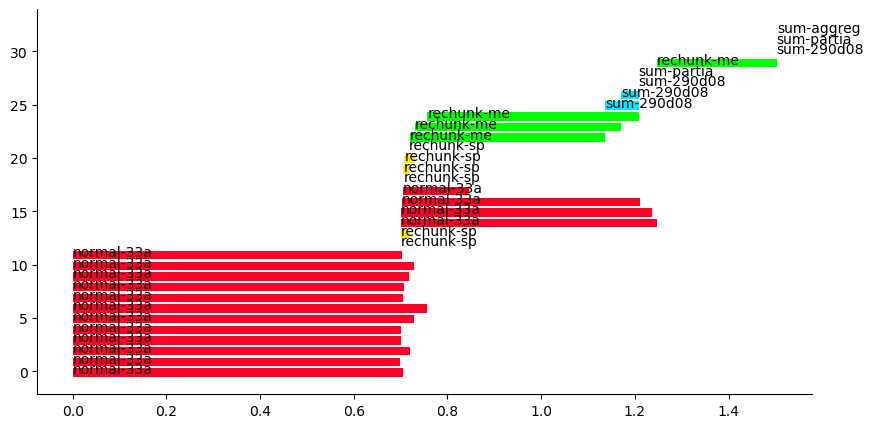

In [13]:
colors = ['red', 'yellow', 'lightgreen', 'lightblue', 'tab:orange', 'tab:pink']
d_c = dict(zip(df2['task_type'].unique(),colors))
d_c

{'normal': 'red',
 'rechunk-split': 'yellow',
 'rechunk-merge-sum': 'lightgreen',
 'sum': 'lightblue',
 'sum-partial': 'tab:orange',
 'sum-aggregate': 'tab:pink'}

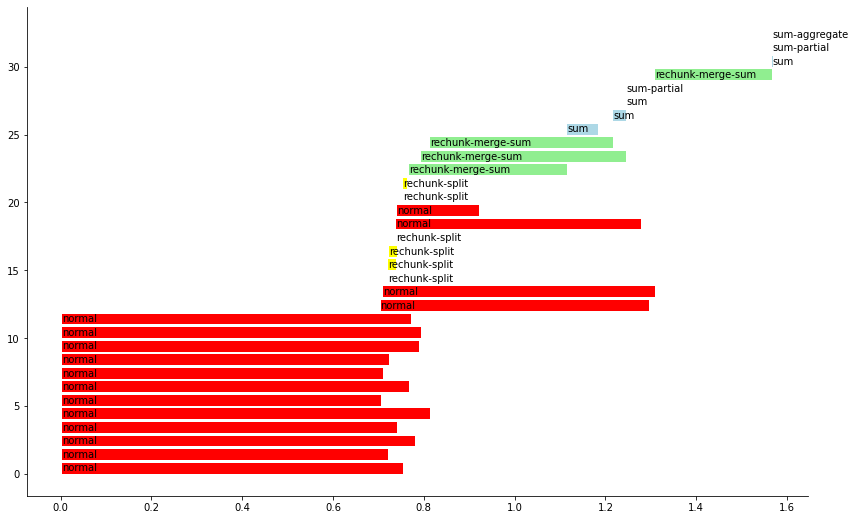

In [14]:
fig, ax = plt.subplots(figsize=(14,9))

for i,v in enumerate(df2.values):
    ax.broken_barh([(v[1], v[4])], (i, 0.8), 
                   facecolors=d_c[v[5]])
    
    ax.annotate(v[5], (v[1], i+0.2), fontsize=10)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

<p class="task" id="4"></p>

4\. Воспользовавшись функцией `dask.datasets.make_people`, сгенерируйте `Bag` со следующими характеристиками:

* кол-во сегментов - 25;
* кол-во элементов в одном сегменте - 20 тыс;
* seed=42

Посчитайте, сколько людей в полученном наборе данных проживают в городе "Las Vegas". Выведите это количество на экран. Для демонстрации прогресса вычислений воспользуйтесь `dask.diagnostics.ProgressBar`.

In [15]:
#!pip install mimesis

In [16]:
bg4 = dask.datasets.make_people(npartitions=25, records_per_partition=20_000, seed=42)

In [17]:
with ProgressBar():
    res4 = bg4.fold(
        lambda acc, val: acc+1 if val['address']['city']=='Las Vegas' else acc,
        lambda acc, val: acc+val,
        initial=0
    ).compute()

res4

[########################################] | 100% Completed | 10.92 s


288

<p class="task" id="5"></p>

5\. Воспользовавшись `Bag`, полученном в задании 4, посчитайте и выведите на экран, сколько людей в полученном наборе данных проживают в городе "Las Vegas", используя различные планировщики:
* планировщик на потоках;
* планировщик на процессах;
* синхронный планировщик (1 поток).

При выполнении вычислений используйте `ProgressBar` для замера времени.

Сделайте вывод в виде текстового комментария.

In [18]:
with ProgressBar():
    res5 = bg4.fold(
        lambda acc, val: acc+1 if val['address']['city']=='Las Vegas' else acc,
        lambda acc, val: acc+val,
        initial=0
    ).compute(scheduler="threads")

res5

[########################################] | 100% Completed | 33.71 s


288

In [19]:
with ProgressBar():
    res5 = bg4.fold(
        lambda acc, val: acc+1 if val['address']['city']=='Las Vegas' else acc,
        lambda acc, val: acc+val,
        initial=0
    ).compute(scheduler="processes")

res5

[########################################] | 100% Completed | 11.21 s


288

In [20]:
with ProgressBar():
    res5 = bg4.fold(
        lambda acc, val: acc+1 if val['address']['city']=='Las Vegas' else acc,
        lambda acc, val: acc+val,
        initial=0
    ).compute(scheduler="sync")

res5

[########################################] | 100% Completed | 34.90 s


288

<p class="task" id="6"></p>

6\. Воспользовавшись `da.random.RandomState`, укажите зерно ГПСЧ, равное 42, и создайте массив `arr` из 1 млн. строк и 312 столбцов, заполненный числами из стандартного нормального распределения. Создайте массив `arr_masked`, содержащий строки из массива `arr`, для которых целая часть модуля суммы элементов нацело делится на 5.

Вычислите и выведите на экран сумму элементов массива и корень из суммы квадратов всех элементов массива. Выведите на экран эти значения и суммарное время вычисления двух этих значений.

In [21]:
%%time
s6 = da.random.RandomState(42).normal(0, 1, size=(1_000_000, 312))
mask6 = da.trunc(s6.sum(axis=1))%5 == 0
arr_masked6 = s6[mask6]

# 2 compute по отдельности
arr_masked6.sum().compute(), da.sqrt((arr_masked6**2).sum()).compute()

Wall time: 3.24 s


(3575.50593956595, 8243.167316557918)

In [22]:
%%time
s6 = da.random.RandomState(42).normal(0, 1, size=(1_000_000,312))
mask6 = da.trunc(s6.sum(axis=1))%5 == 0
arr_masked6 = s6[mask6]

# 2 compute вместе
dask.compute(arr_masked6.sum(), da.sqrt((arr_masked6**2).sum()))

Wall time: 1.69 s


(3575.50593956595, 8243.167316557918)

<p class="task" id="7"></p>

7\. Повторите решение задачи 6, предрассчитав значения `arr_masked` при помощи метода `persist`. Сравните время выполнения двух решений. Выведите на экран время выполнения вызова `arr_masked.compute()`. 

In [23]:
%%time
s7 = da.random.RandomState(42).normal(0, 1, size=(1_000_000,312))
mask7 = da.trunc(s7.sum(axis=1))%5 == 0
arr_masked7 = s7[mask7].persist()

# 2 compute по отдельности
arr_masked7.sum().compute(), da.sqrt((arr_masked7**2).sum()).compute()

Wall time: 1.67 s


(3575.50593956595, 8243.167316557918)

In [24]:
%%time
s7 = da.random.RandomState(42).normal(0, 1, size=(1_000_000,312))
mask7 = da.trunc(s7.sum(axis=1))%5 == 0
arr_masked7 = s7[mask7].persist()

# 2 compute вместе
dask.compute(arr_masked7.sum(), da.sqrt((arr_masked7**2).sum()))

Wall time: 1.68 s


(3575.50593956595, 8243.167316557918)

In [25]:
%%time
arr_masked7.compute()

Wall time: 110 ms


array([[-0.42938349,  0.64227945,  0.22879528, ...,  0.05544971,
        -0.46384387,  1.46690874],
       [-0.00796584,  1.39965937, -0.84931403, ...,  0.36593278,
         1.67044616, -0.18697098],
       [ 0.70615384, -0.48932103,  0.98484413, ...,  0.46006069,
        -0.55353232, -1.01782818],
       ...,
       [ 0.11114669, -0.53632791,  0.35354556, ...,  0.06506191,
         0.07241935, -1.0614157 ],
       [ 0.0107234 ,  0.20993128, -0.97736133, ..., -0.21454792,
         1.96425228, -0.35827931],
       [-0.04479738, -0.55849487, -1.74682426, ..., -0.09201292,
         0.89438255, -1.84690731]])

<p class="task" id="8"></p>

8\. Запустите `dask.distributed.Client`. Воспользовавшись `Bag`, полученном в задании 4, посчитайте, сколько людей в полученном наборе данных проживают в городе "Las Vegas". Проведите расчеты двумя способами:
* с использованием блокирующего вызова `Bag.compute`
* с использованием неблокирующего вызова `Client.compute`

Используя дашборд, который предоставляет `dask.distributed.Client`, сделайте и вставьте в ноутбук скриншоты 
* хода процесса вычислений (вкладка Status)
* графа вычислений (вкладка Graph)

In [26]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51607,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.81 GiB
Comm: tcp://127.0.0.1:51627,Total threads: 3
Dashboard: http://127.0.0.1:51632/status,Memory: 3.95 GiB
Nanny: tcp://127.0.0.1:51610,


In [27]:
res8 = bg4.fold(
    lambda acc, val: acc+1 if val['address']['city']=='Las Vegas' else acc,
    lambda acc, val: acc+val,
    initial=0
)

In [28]:
%%time
res8.compute()

Wall time: 13.7 s


288

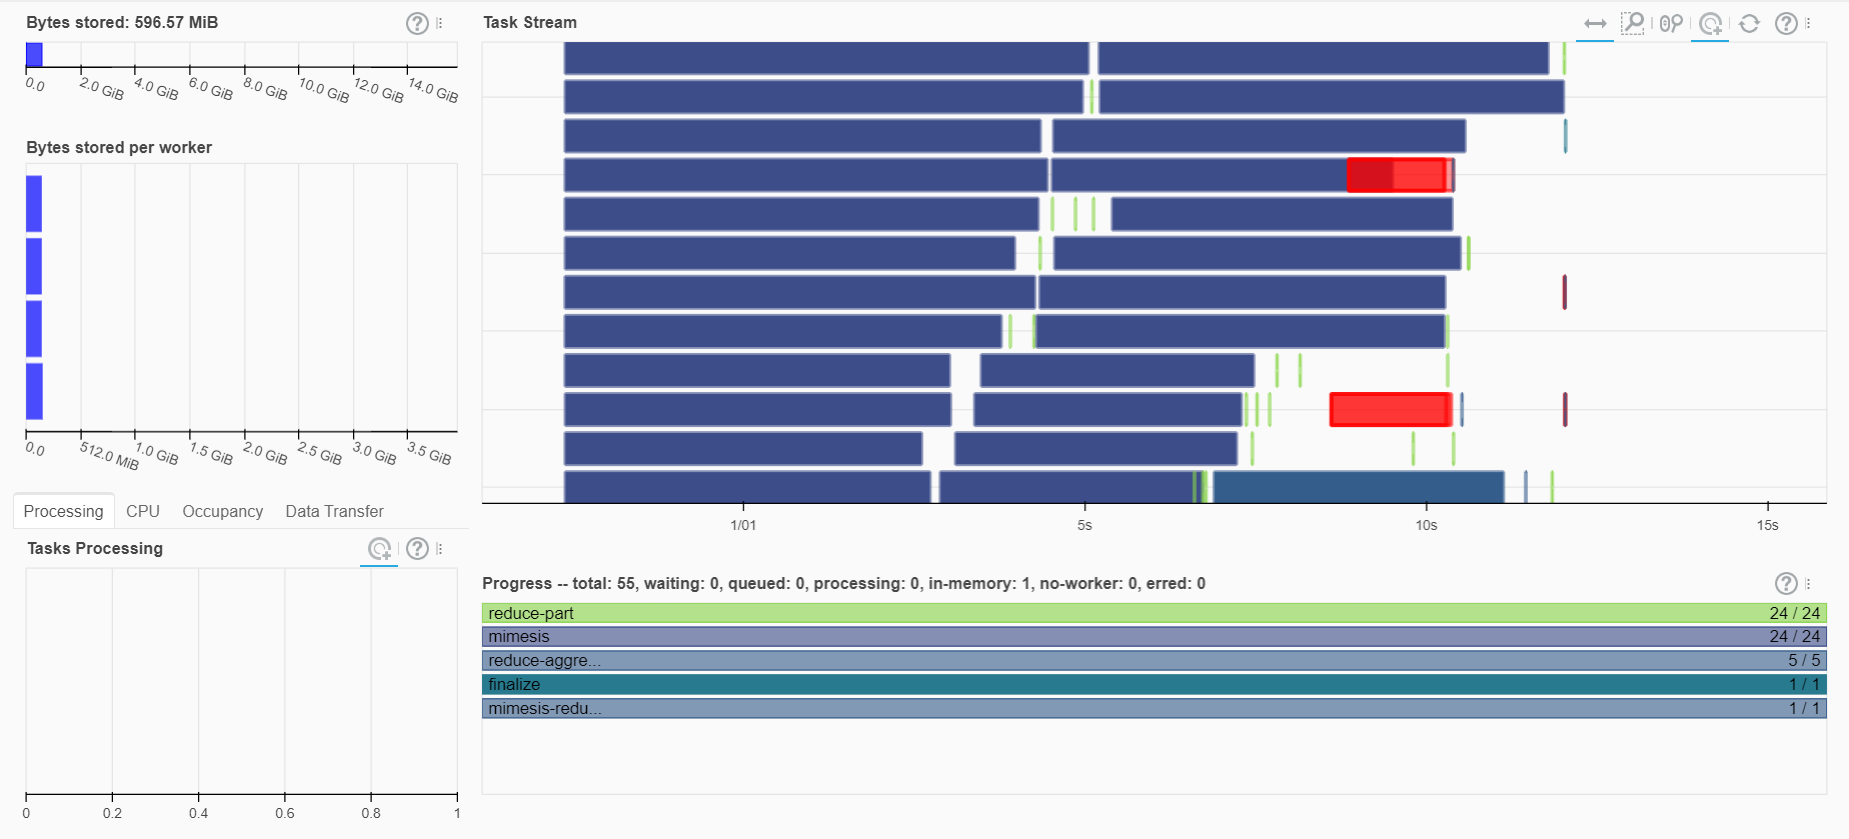

In [29]:
%%time
res_cl8 = client.compute(res8)
res_cl8.result()

Wall time: 13 s


288

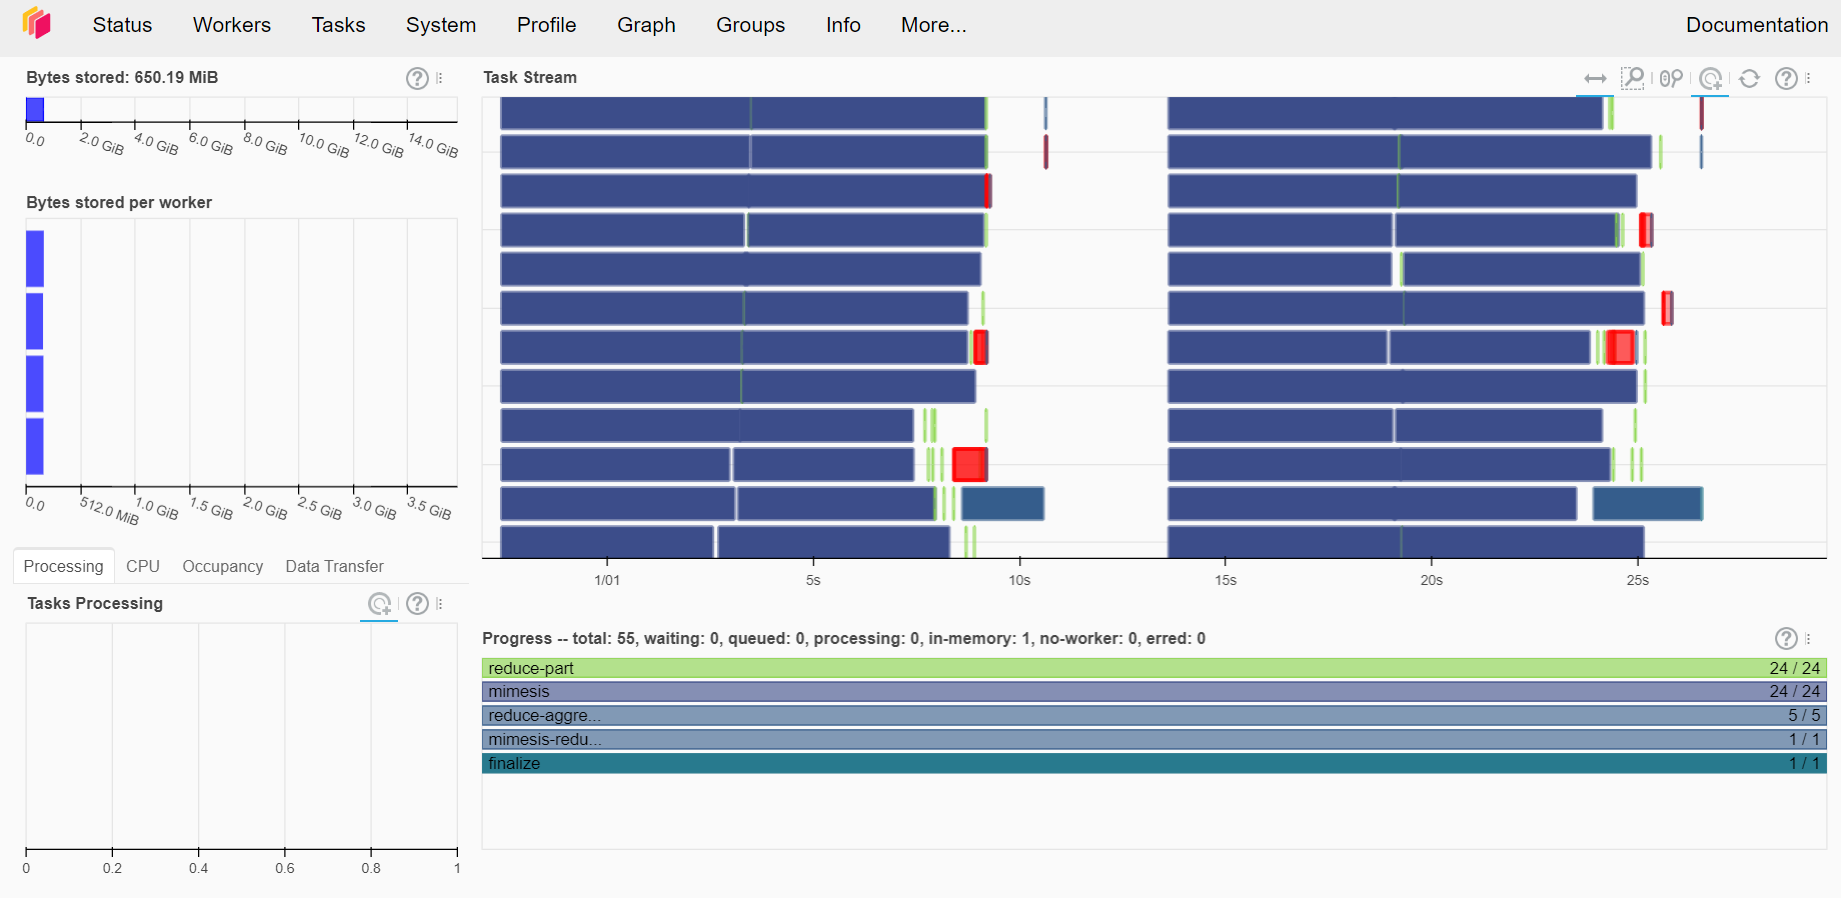

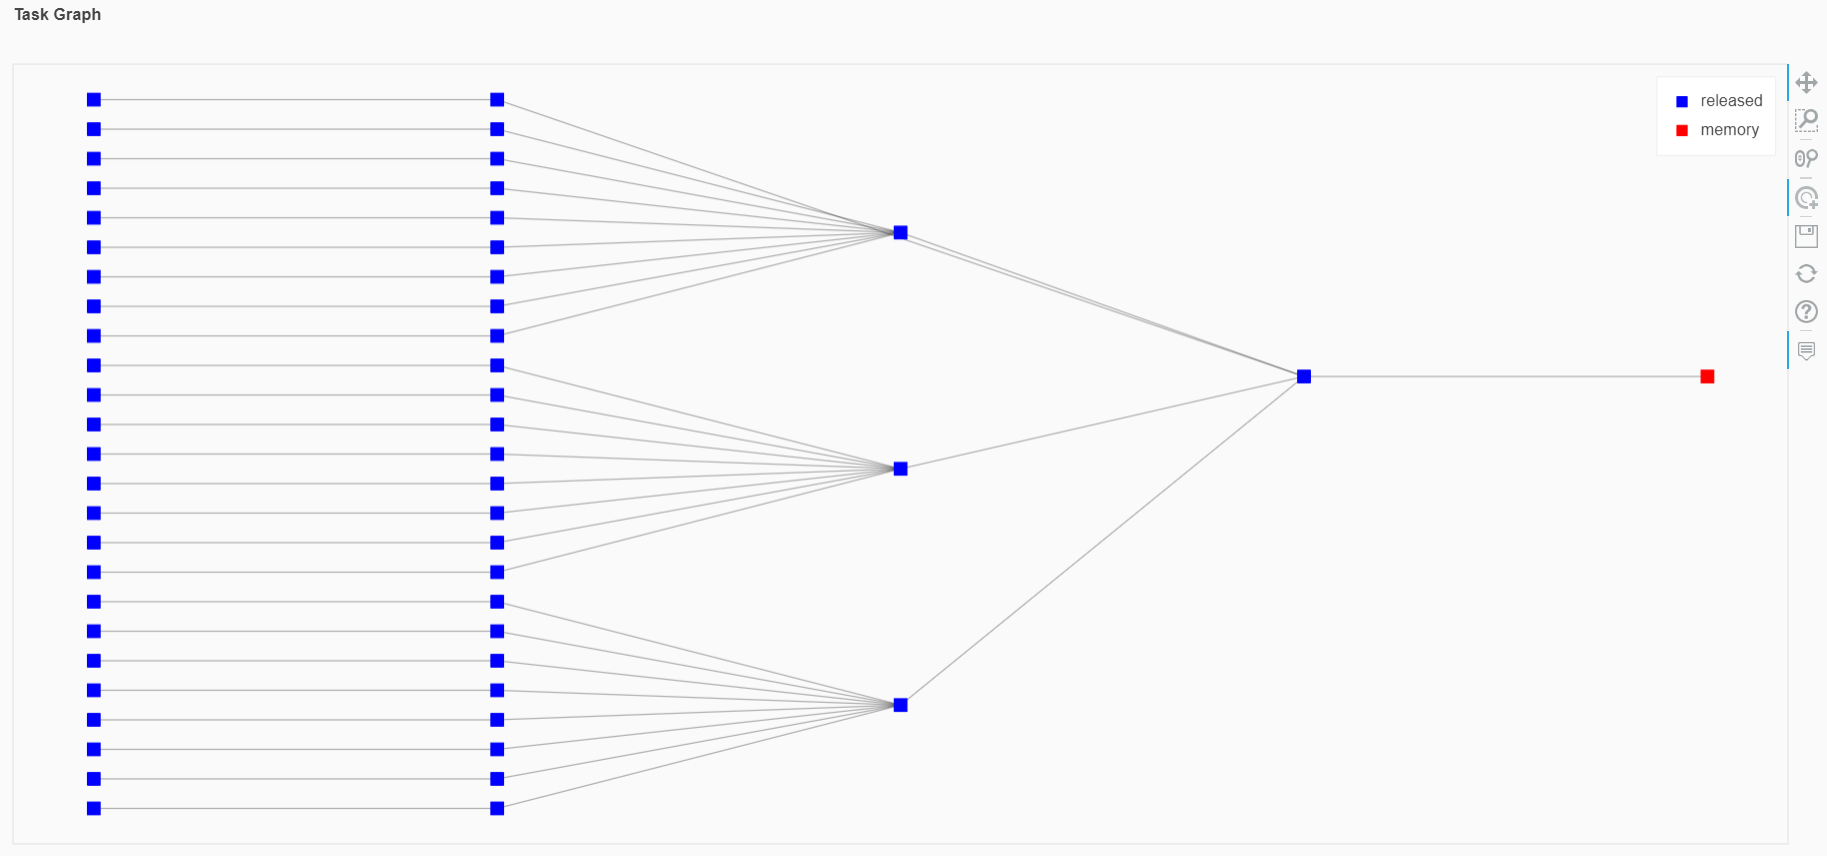

In [30]:
%%time
res_cl8.result()

Wall time: 2.97 ms


288

<p class="task" id="9"></p>

9\. Запустите `dask.distributed.Client`. Воспользовавшись `Bag`, полученном в задании 4, создайте `Bag` `young_people`, содержащий записи о людях, которым не более 50 лет. Вычислите и выведите на экран должность (`occupation`), которая встречается чаще всего, а также количество уникальных имен (имя хранится элементе с индексом 1 кортежа под ключом `name`). Выведите на экран эти значения и суммарное время вычисления двух этих значений.

In [31]:
%%time
bg9 = bg4.filter(
    lambda x: x['age']<=50
)

freq_occ = bg9.pluck('occupation').frequencies(sort=True)
res_freq_occ = client.compute(freq_occ)

cnt_dist_names = bg9.distinct(key=lambda x: x['name'][1]).count()
res_cnt_dist_names = client.compute(cnt_dist_names)

res_freq_occ.result()[0], res_cnt_dist_names.result()

Wall time: 25.4 s


(('Medical Officer', 348), 1000)

In [32]:
%%time
res_freq_occ.result()[0], res_cnt_dist_names.result()

Wall time: 73.7 ms


(('Medical Officer', 348), 1000)

<p class="task" id="10"></p>

10\. Повторите решение задачи 9, предрассчитав значения `young_people` при помощи метода `persist`. Обратите внимание, что при запущенном `Client` метод `Bag.persist` стал неблокирующим. Отследите в дашборде (сделайте и вставьте скриншот) процедуру выполнения метода `persist`. После того, как он закончится, приступайте к дальнейшим вычислениям.

Сравните время выполнения двух решений.

In [33]:
%%time
bg10 = bg4.filter(
    lambda x: x['age']<=50
).persist()

Wall time: 5.98 ms


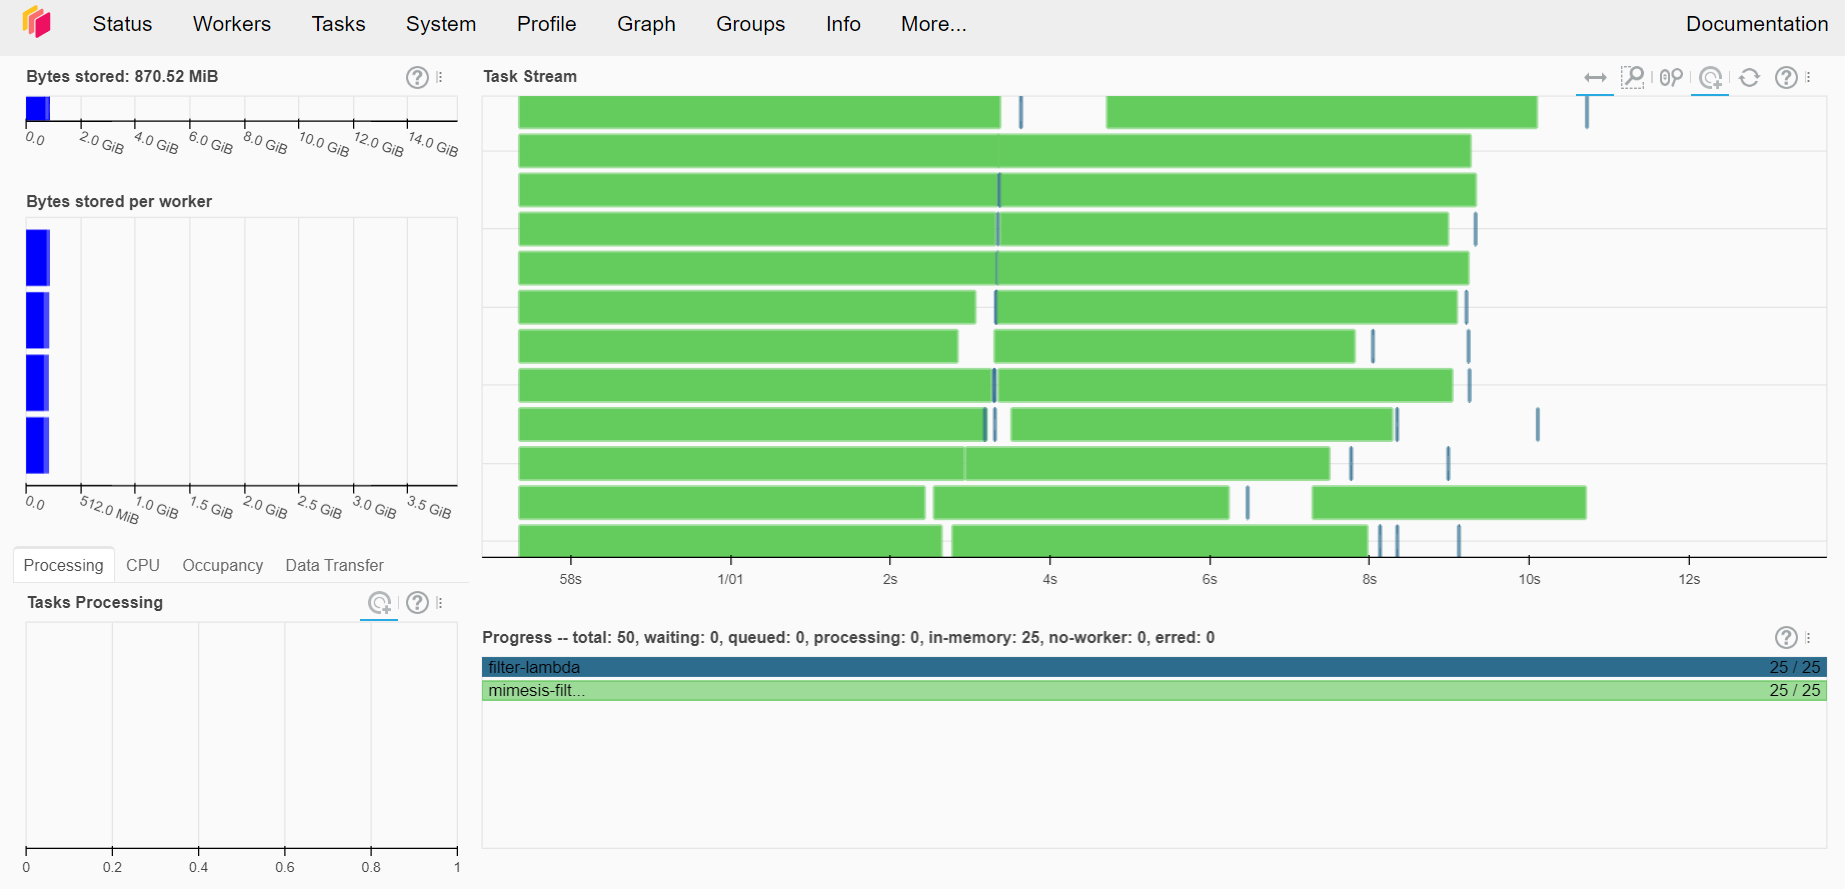

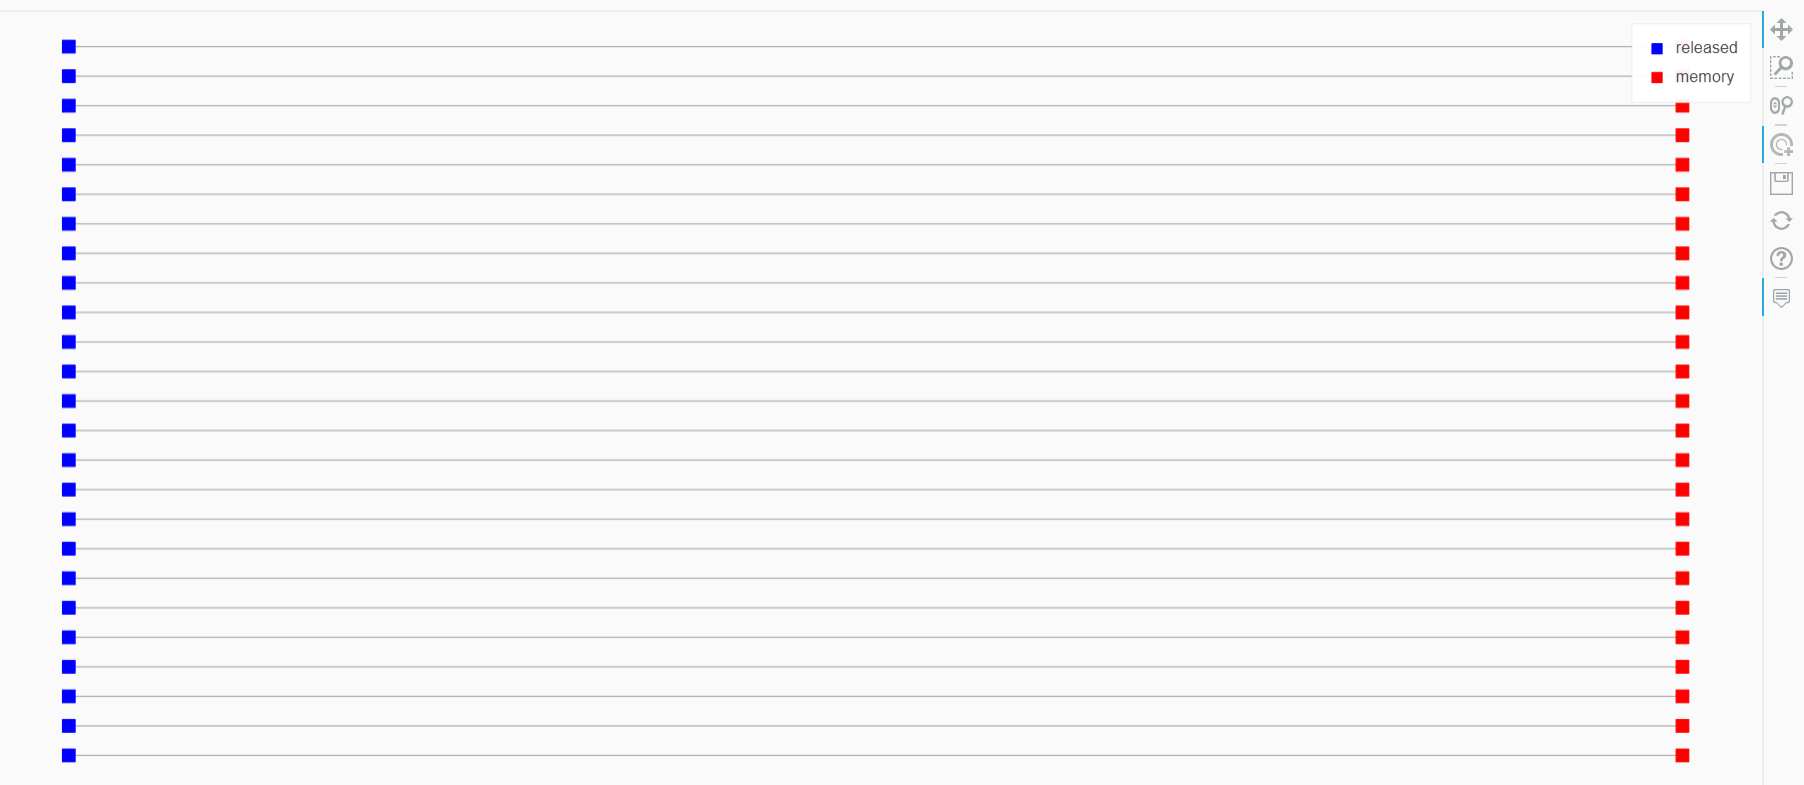

In [34]:
%%time
freq_occ10 = bg10.pluck('occupation').frequencies(sort=True)
res_freq_occ10 = client.compute(freq_occ10)

cnt_dist_names10 = bg10.distinct(key=lambda x: x['name'][1]).count()
res_cnt_dist_names10 = client.compute(cnt_dist_names10)

res_freq_occ10.result()[0], res_cnt_dist_names10.result()

Wall time: 833 ms


(('Medical Officer', 348), 1000)

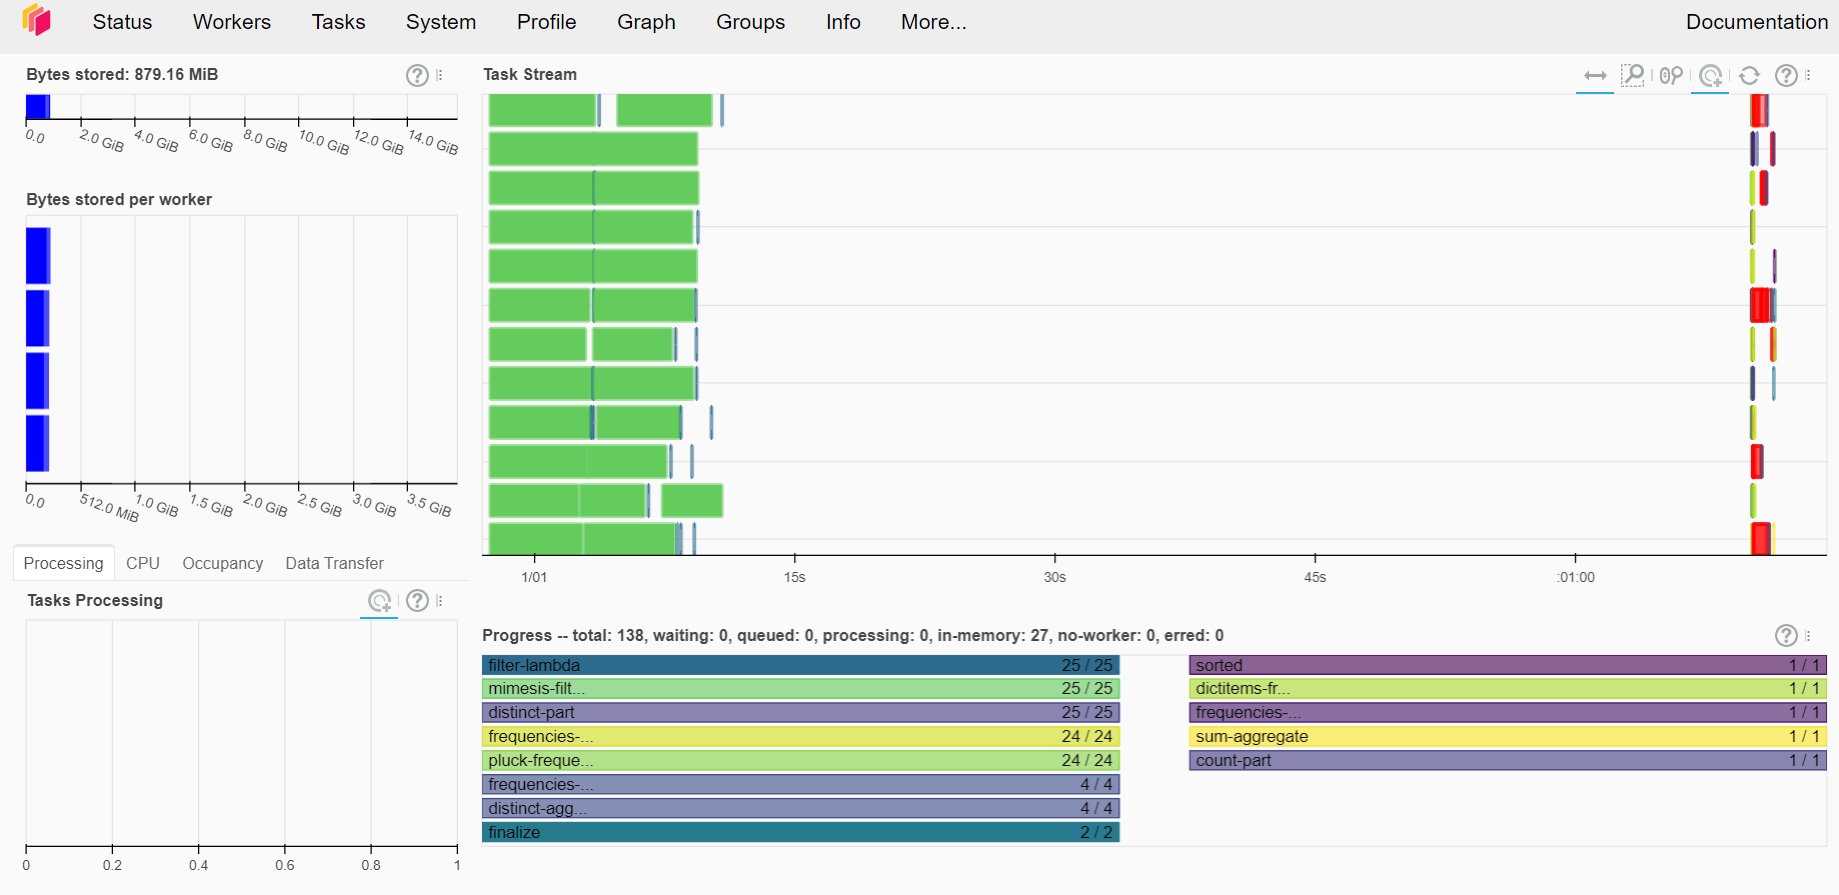

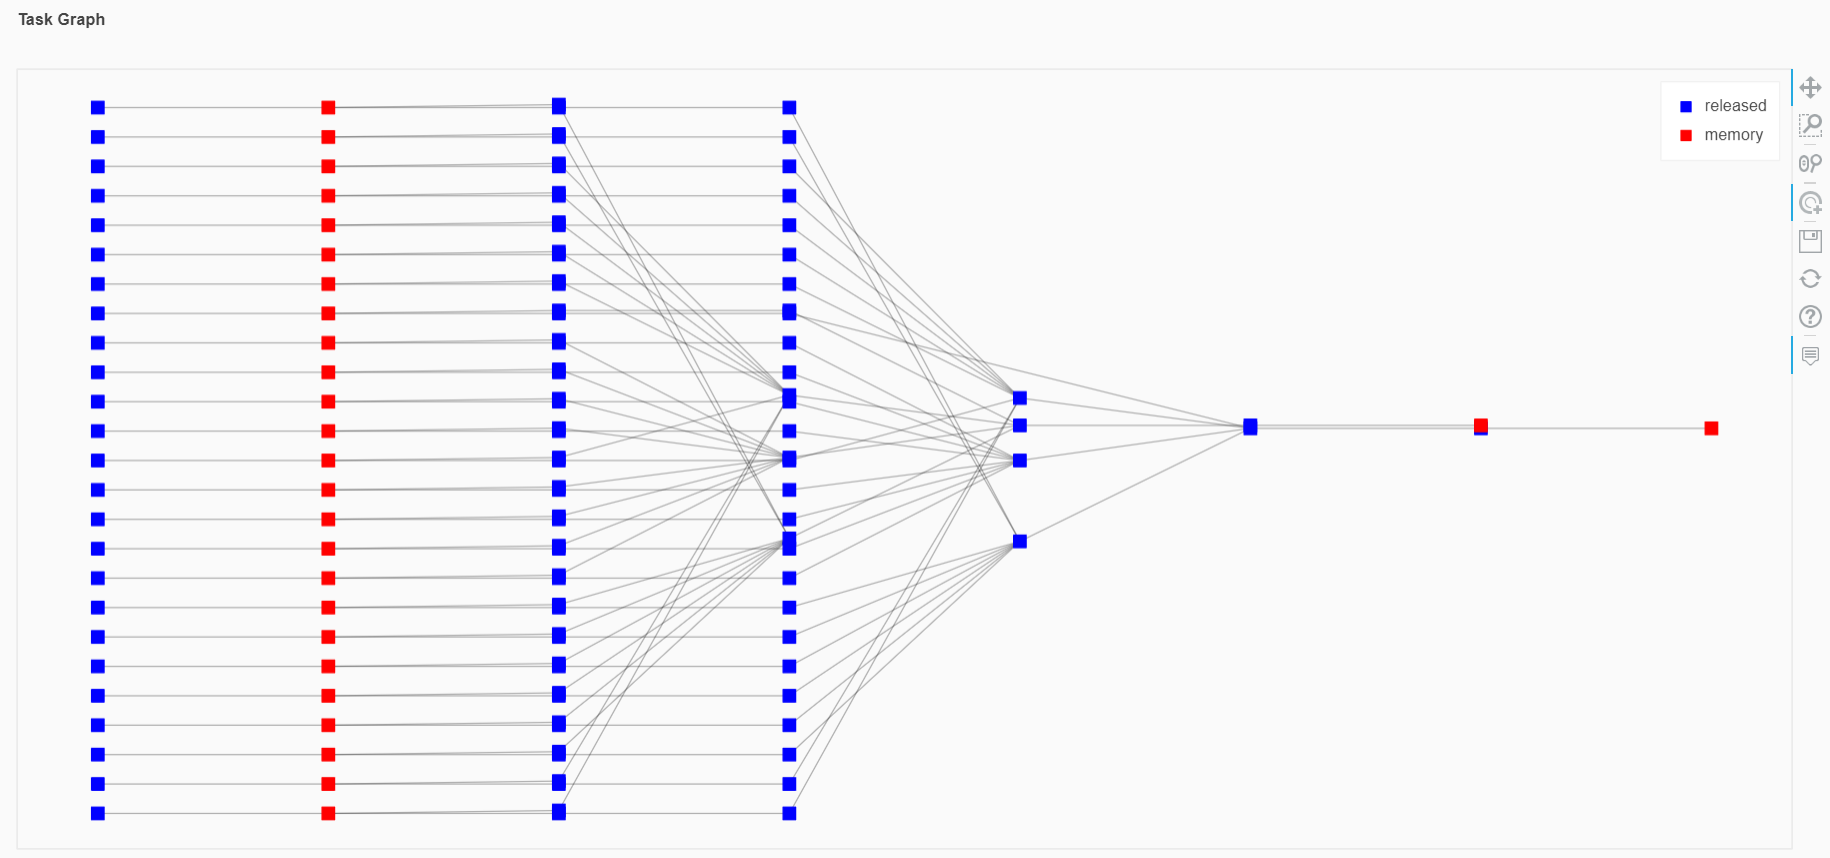

In [35]:
client.close()